# Spin Classification Model

A deep learning model to classify quantum spin configurations

In [57]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

### Loading Datasets

You can load different datasets by changing the dataset path for testing, trainging, and benchmarking

In [58]:
# Set these variables to the appropriate directory paths

test_dir = '../data/binary_class/test/'
train_dir = '../data/binary_class/train/'

# Set these variables to the appropriate directory paths
benchmark_dir = '../data/temp_class/test/'

In [59]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

#create datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=dset_transform)
test_data = datasets.ImageFolder(test_dir, transform=dset_transform)
benchmark_data = datasets.ImageFolder(benchmark_dir, transform=dset_transform)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

## Architecture

This is the basic architecture of the model. The following parameters can be set:

* `input_size`: The dimensions of the input images. Default: `[25, 25]`
* `hidden_layers`: The number of hidden layers in the model. Default: 5
* `layer_size`: The size of each hidden layer. Default: 128
* `conv`: Boolean to determine if the network should be fully connected or convolutional. Default: False
* `num_classes`: The number of output classes. Leave as 2 for binary classification. Otherwise set to number of temperature values for which data is available. Default: 2


In [60]:
input_size = [25,25]
hidden_layers = 5
layer_size = 128
conv = False # True for convolutional, False for fully connected
num_classes = 2

In [61]:
def linear_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Linear(layer_size, layer_size))
        layers.append(nn.ReLU())
    return layers
    

In [62]:
def conv_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Conv2d(layer_size, layer_size, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return layers

In [63]:
class SpinClassifier(nn.Module): 
    def __init__(self, input_size, hidden_layers, layer_size, num_classes, conv):
        super(SpinClassifier, self).__init__()
        self.conv = conv
        self.input_dim = np.prod(input_size)
        self.output_dim = num_classes
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        self.input_layer = [nn.Linear(self.input_dim, self.layer_size), nn.ReLU()]
        self.output_layer = [nn.Linear(self.layer_size, self.output_dim)]
        if self.conv:
            self.layers = conv_block(self.layer_size, self.num_layers)
        else:
            self.layers = linear_block(self.layer_size, self.num_layers)
        
        self.model = nn.Sequential(*self.input_layer, *self.layers, *self.output_layer)


        
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)
        

Now we can set up the model and the training

In [68]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [69]:
model = SpinClassifier(input_size, hidden_layers, layer_size, num_classes, conv).to(DEVICE)

max_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

save_path = './models/Spin_Classifier.pt'
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

### Trainging the model

In [70]:
train_loss_history = []
test_loss_history = []

for epoch in range(max_epochs):

    train_loss = 0.0
    test_loss = 0.0

    for i, data in enumerate(train_loader):

        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        predicted_output = model(images)
        fit = criterion(predicted_output, labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item() / len(train_data)

    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        predicted_output = model(images)
        fit = criterion(predicted_output, labels)
        test_loss += fit.item() / len(test_data)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}')

RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

Now we can plot our loss to see how the model improved over time

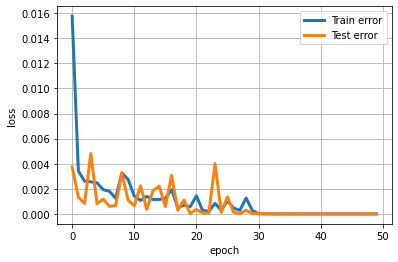

In [67]:
plt.plot(range(max_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(max_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()